In [26]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
import string
import nltk # 用于处理人类语言数据的符号和统计自然语言处理（NLP）。它提供了文本处理库用于分类、标记、语法分析、语义推理等。
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
import numpy as np
import pandas as pd
# CountVectorizer: 用于将一系列文档转换成向量的形式，计算每个单词在文档中出现的次数。
# TfidfTransformer: 将通过 CountVectorizer 得到的词频（term frequency）矩阵转换成 TF-IDF 表示。
# TF-IDF（Term Frequency-Inverse Document Frequency）是一种统计方法，用以评估一个字词对于一个文件集或一个语料库中的其中一份文件的重要程度。
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
# 能够把数据集分割成 K 个子集，用于模型训练和验证，帮助评估模型的性能。
# from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
# corpora: 用于创建和操作语料库的模块，可以将文档集转换成矩阵表示，用于后续的主题模型或其他模型训练。
from gensim.models.ldamodel import LdaModel
# LdaModel (Latent Dirichlet Allocation model): 是一个用于文档集主题建模的工具，可以从文档集中发现主题，并根据这些主题自动分类文档。
from gensim import corpora
# WordNetLemmatizer 来自 nltk.stem.wordnet: 用于词形还原，将单词还原到基本形式，以便于文本处理时减少单词的多样性而不改变其原意。
from nltk.stem.wordnet import WordNetLemmatizer
from tqdm import tqdm
# tabulate: 用于打印表格数据的库，可以将数据以文本表格的形式输出，便于阅读和展示。
from tabulate import tabulate
from torchfm.model.dcn import DeepCrossNetworkModel



def load_df(dataset_name):
    if dataset_name in ['reddit_500', 'reddit']:
        file_name = '../data/reddit.csv'
        df = pd.read_csv(file_name)
        return df
    else:
        raise ValueError("Error: unrecognized dataset")


# 处理文本数据，将这些文本转换为TF-IDF特征矩阵。
def f_tfidf(data):
    print("Processing TF-IDF features ...")
    X = []
    for t in data['Post']:
        X.append(t)
    # 这个对象用于将文本转换为词频矩阵。它配置了三个参数：移除英文停用词，只考虑单个词的n-grams，最多考虑频率最高的50个词。
    count_vect = CountVectorizer(stop_words='english', ngram_range=(1, 1), max_features=50)
    X_counts = count_vect.fit_transform(X)
    word = count_vect.get_feature_names_out()
    tfidf_transformer = TfidfTransformer()
    X_tfidf = tfidf_transformer.fit_transform(X_counts)
        # 将稀疏矩阵转换为稠密矩阵，并创建DataFrame
    df_tfidf = pd.DataFrame(X_tfidf.todense(), columns=word)
    
    # 保存DataFrame到CSV文件
    df_tfidf.to_csv('tfidf_features.csv', index=False)

    return pd.DataFrame(X_tfidf.todense(), columns=word)



# args = arg_clf()
df_data = load_df('reddit')
df_tfidf = f_tfidf(df_data)

Processing TF-IDF features ...


In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec = TfidfVectorizer()
# stop words自定义停用词表，为列表List类型
# token_pattern过滤规则，正则表达式，如r"(?u)bw+b
# max_df=0.5，代表一个单词在 50% 的文档中都出现过了，那么它只携带了非常少的信息，因此就不作为分词统计
documents = [
    'this is the bayes document',
    'this is the second second document',
    'and the third one',
    'is this the document'
]
tfidf_matrix = tfidf_vec.fit_transform(documents)
# 拟合模型，并返回文本矩阵  表示了每个单词在每个文档中的 TF-IDF 值
print('输出每个单词在每个文档中的 TF-IDF 值，向量里的顺序是按照词语的 id 顺序来的:', '\n', tfidf_matrix.toarray())
print('不重复的词:', tfidf_vec.get_feature_names())
print('输出每个单词对应的 id 值:', tfidf_vec.vocabulary_)
print('返回idf值:', tfidf_vec.idf_)
print('返回停用词表:', tfidf_vec.stop_words_)


输出每个单词在每个文档中的 TF-IDF 值，向量里的顺序是按照词语的 id 顺序来的: 
 [[0.         0.63314609 0.40412895 0.40412895 0.         0.
  0.33040189 0.         0.40412895]
 [0.         0.         0.27230147 0.27230147 0.         0.85322574
  0.22262429 0.         0.27230147]
 [0.55280532 0.         0.         0.         0.55280532 0.
  0.28847675 0.55280532 0.        ]
 [0.         0.         0.52210862 0.52210862 0.         0.
  0.42685801 0.         0.52210862]]


AttributeError: 'TfidfVectorizer' object has no attribute 'get_feature_names'

In [65]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# 创建 SentimentIntensityAnalyzer 对象
analyzer = SentimentIntensityAnalyzer()

# 要分析的文本
text = " ['Its not a viable option, and youll be leaving your wife behind. Youd Pain her beyond comprehension.It sucks worrying about money, I know that first hand. It can definitely feel hopeless, as you seem to be Tired aware of. Your wife might need to chip in financially. I know time is an issue, but even 10-15 hours a Asthenia could alleviate a lot of the pressure. In the meantime, get your shit together - write that resume tomorrow. No excuses, get it done and send it out. Whether you believe in some sort of powerful being or force governing things or not, things really do work themselves out. This is a big test for you, and youll pull through. Just try to stay as positive as you can and everything will work out.']"

# 获取情感分析结果
sentiment_score = analyzer.polarity_scores(text)

# 输出情感分析结果
print("情感分析结果:", sentiment_score)

# print()
for k, v in sentiment_score.items():
    print('{0}: {1}, '.format(k, v), end='')


情感分析结果: {'neg': 0.131, 'neu': 0.79, 'pos': 0.079, 'compound': -0.7131}
neg: 0.131, neu: 0.79, pos: 0.079, compound: -0.7131, 

In [2]:
import nltk
from nltk.tokenize import word_tokenize

# 待分词的文本
text = "NLTK is a leading platform for building Python programs to work with human language data.data ,DATA;;"""""""

# 使用word_tokenize函数对文本进行分词
tokens = word_tokenize(text)

# 输出分词结果
print(tokens)


['NLTK', 'is', 'a', 'leading', 'platform', 'for', 'building', 'Python', 'programs', 'to', 'work', 'with', 'human', 'language', 'data.data', ',', 'DATA', ';', ';']


In [10]:
import nltk
from nltk.tokenize import sent_tokenize

# 待分割成句子的文本
text = "NLTK is a leading platform ! ,/ 。 for building Python programs . to work with human lan  guage data. It provides easy-to-use, interfaces to . over 50 corpora and lexical resources such as WordNet, along with a suite of text processing libraries for classification, tokenization, stemming, tagging, parsing, and semantic reasoning."

# 使用 sent_tokenize 函数将文本分割成句子
sentences = sent_tokenize(text)

# 输出分割后的句子
for sentence in sentences:
    print(sentence)


NLTK is a leading platform !
,/ 。 for building Python programs .
to work with human lan  guage data.
It provides easy-to-use, interfaces to .
over 50 corpora and lexical resources such as WordNet, along with a suite of text processing libraries for classification, tokenization, stemming, tagging, parsing, and semantic reasoning.


In [15]:
from tools import utils
reddit =  utils.load_df('reddit_500')
print(reddit['Post'][0])

ModuleNotFoundError: No module named 'tools'

In [22]:
import json

# 假设有一个JSON格式的字符串，它表示一个数组
json_string = '["i am 13 years old", "i am feel good,days goods ,,???", "i feel sadness"]'

# 使用json模块解析字符串
parsed_array = eval(json_string)

# 输出转换后的数组（列表）
print(parsed_array)


['i am 13 years old', 'i am feel good,days goods ,,???', 'i feel sadness']


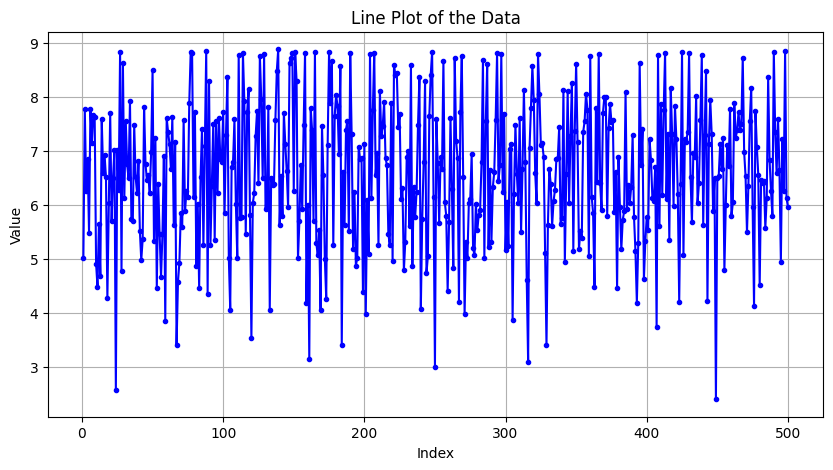

In [41]:
# 假设这里我们有一些模拟的句子数量数据
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



# 创建 DataFrame
df = pd.read_csv('./features.csv')

# 绘制原始数据的直方图
# 给定的数据
# data = [1, 2, 3, 4, 5, 600]

# 创建一个序列用于X轴
x = range(1, 501)

# 绘制折线图
plt.figure(figsize=(10, 5))
plt.plot(x, np.log1p(df['pos_token']), marker='.', linestyle='-', color='b')
plt.title('Line Plot of the Data')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()






In [39]:
import numpy as np
import pandas as pd

# 假设这是我们的极度偏斜的数据
data = [1, 2, 3, 4, 5, 600, 2300,7540]

# 将数据转换为 DataFrame
df = pd.DataFrame(data, columns=['Original Data'])

# 应用对数转换，这里加1是为了避免对0取对数的情况
df['Log Transformed Data'] = np.log1p(df['Original Data'])
print(df['Log Transformed Data'])

df


0    0.693147
1    1.098612
2    1.386294
3    1.609438
4    1.791759
5    6.398595
6    7.741099
7    8.928110
Name: Log Transformed Data, dtype: float64


,Original Data,Log Transformed Data
0,1,0.693147
1,2,1.098612
2,3,1.386294
3,4,1.609438
4,5,1.791759
5,600,6.398595
6,2300,7.741099
7,7540,8.928110


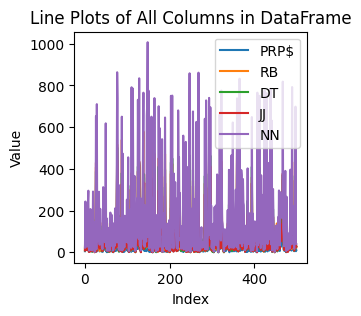

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 用 pd.read_csv() 读取 CSV 文件
df = pd.read_csv('./tag_count_body.csv')  # 替换 'your_file_path.csv' 为你的 CSV 文件路径

# 设置图形大小
plt.figure(figsize=(3, 3))

# 遍历 DataFrame 的每一列
for column in df.columns[:5]:
    # plt.plot(np.log1p(df[column]), label=column)  # 绘制每一列的折线图，并添加标签
    plt.plot(df[column], label=column)  # 绘制每一列的折线图，并添加标签

# 添加图例
plt.legend()

# 添加标题和坐标轴标签
plt.title('Line Plots of All Columns in DataFrame')
plt.xlabel('Index')
plt.ylabel('Value')

# 显示图形
plt.show()


In [1]:
# 在数据上的验证，利用机器学习
   # print('Accuracy: {:.2f}%'.format(100 * correct / total))
    # print('Finished...')


    # 训练模型
    # 初始化逻辑回归模型
    # model = LogisticRegression(penalty='l2', tol=1e-6, max_iter=10000, random_state=seed, multi_class='multinomial', solver='lbfgs')
    # model = RandomForestClassifier(n_estimators=20, max_depth=8, random_state=0)
#     dtrain = xgb.DMatrix(train_data, label=train_labels, missing=-999)
#     dtest = xgb.DMatrix(test_data, label=test_labels, missing=-999)
# # 参数调整为多分类场景
#     params = {
#         'max_depth': 10,
#         'eta': 0.1,
#         'verbosity': 0,  # 更新参数以控制输出信息
#         'objective': 'multi:softmax',  # 修改为多分类的目标函数
#         'num_class': 5,  # 假设有3个类别
#         'nthread': -1
#     }
#     num_round = 10000
#     watchlist = [(dtrain, 'train'), (dtest, 'test')]
#     model = xgb.train(params, dtrain, num_round, watchlist, early_stopping_rounds=50, verbose_eval=10)

#     # 训练模型
#     # model.fit(train_data, train_labels)
#     # 在测试集上进行预测
#     y_pred = model.predict(dtest)

#     # 计算精确性
#     accuracy = accuracy_score(test_labels, y_pred)
#     print(f"Accuracy: {accuracy}")



    # 训练模型    
    # num_fold = 5
    # kf = KFold(n_splits=num_fold, shuffle=True, random_state=0)
    # for train_index, test_index in kf.split(X):
    #     X_train, X_test = X[train_index], X[test_index]
    #     y_train, y_test = Y[train_index], Y[test_index]
    #     dtrain = xgb.DMatrix(train_data, label=train_labels, missing=-999)
    #     dtest = xgb.DMatrix(test_data, label=test_labels, missing=-999)
    # # 参数调整为多分类场景
    #     params = {
    #         'max_depth': 10,
    #         'eta': 0.1,
    #         'verbosity': 0,  # 更新参数以控制输出信息
    #         'objective': 'multi:softmax',  # 修改为多分类的目标函数
    #         'num_class': 5,  # 假设有3个类别
    #         'nthread': -1
    #     }
    #     num_round = 10000
    #     watchlist = [(dtrain, 'train'), (dtest, 'test')]
    #     model = xgb.train(params, dtrain, num_round, watchlist, early_stopping_rounds=50, verbose_eval=10)
        
    #     # model.fit(X_train, y_train)
    #     y_pred = model.predict(dtest)
    #     accuracy = accuracy_score(y_test, y_pred)
    #     print(f"Accuracy: {accuracy}")

In [1]:
import torch
import torch.nn as nn
import model_adfs as model


TypeError: __init__() missing 1 required positional argument: 'inputs_dim'

In [8]:
import numpy as np

inputs_dim = {
        'st':2,
        'pos': 44,
        'tfidf': 50,
        'topic': 10,
        'emotion': 4,
        'sd': 4
    }

print(len(inputs_dim))

dims = []
for k, v in inputs_dim.items():
    # print(k, v)
    dims.append(v)


print(dims)
offsets = np.array((0, *np.cumsum(dims)[:-1]), dtype=np.int64)
print('offsets:',offsets)


6
[2, 44, 50, 10, 4, 4]
offsets: [  0   2  46  96 106 110]


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import numpy as np

# 示例数据集
texts = [
    "my life is meaningless i just want to end my life so badly my life is completely empty and i dont want to have to create meaning in it creating meaning is pain how long will i hold back the urge to run my car head first into the next person coming the opposite way when will i stop feeling jealous of tragic characters like gomer pile for the swift end they were able to bring to their lives0",
    "muttering i wanna die to myself daily for a few months now i feel worthless shes my soulmate i cant live in this horrible world without her i am so lonely i wish i could just turn off the part of my brain that feels ",
    "wants more celebrities to come to england i miss florida real bad ",
    "26 mile ride today got to see my brotherinlaw and his family good day so far yard work may be the plan for the afternoon"
]
labels = [1,1,0,0]  # 假设我们有两个类别：0和1


# 步骤1: 文本预处理 (在这个例子中我们跳过，直接使用texts)

# 步骤2: 计算TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

# 步骤3: 计算信息增益 (手动实现)
def calculate_entropy(y):
    if len(y) < 2:  # 避免除以0
        return 0
    counts = np.bincount(y)
    probabilities = counts / len(y)
    entropy = -np.sum([p * np.log2(p) for p in probabilities if p > 0])
    return entropy

def information_gain(X, y):
    # 总体熵
    total_entropy = calculate_entropy(y)
    
    # 特征维度
    features = X.shape[1]
    
    # 保存信息增益
    ig_scores = []
    
    for feature in range(features):
        # 分割数据集
        split_left = []
        split_right = []
        
        for i in range(X.shape[0]):
            if X[i, feature] > 0:
                split_left.append(y[i])
            else:
                split_right.append(y[i])
        
        # 计算加权平均熵
        weighted_entropy = (calculate_entropy(split_left) * len(split_left) + 
                            calculate_entropy(split_right) * len(split_right)) / len(y)
        
        # 计算信息增益
        ig = total_entropy - weighted_entropy
        ig_scores.append(ig)
    
    return np.array(ig_scores)

# 分类标签
y = np.array(labels)
# 计算信息增益
ig_scores = information_gain(tfidf_matrix.toarray(), y)

# 选择顶部N个特征
N = 10
top_features_indices = np.argsort(ig_scores)[-N:]

# 使用所选特征进行分类
X_selected = tfidf_matrix[:, top_features_indices]

# 训练和评估分类器
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.25, random_state=42)
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# 准确度
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.0


: 

In [10]:
import ast
import torch
import torch.nn as nn
import string
import nltk # 用于处理人类语言数据的符号和统计自然语言处理（NLP）。它提供了文本处理库用于分类、标记、语法分析、语义推理等。
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from torchfm.layer import CrossNetwork
from nltk.stem.wordnet import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# from transformers import (AdamW, get_cosine_schedule_with_warmup,get_cosine_with_hard_restarts_schedule_with_warmup)
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
import model_adfs as ADFS
from sklearn.metrics import accuracy_score
from gensim.models.ldamodel import LdaModel
from gensim import corpora
from tools import utils
import matplotlib.pyplot as plt


df_all = pd.read_csv('./srd_features.csv')
X = df_all[df_all.columns[:-1]].to_numpy()
Y = df_all['Label'].to_numpy()

# 5折交叉验证
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
}


# 划分数据集为训练集和测试集
train_data, test_data, train_labels, test_labels = train_test_split(X, Y, test_size=0.2, random_state=42,stratify=Y)


# 创建训练集和测试集的Dataset实例
train_dataset = ADFS.CustomDataset(train_data, train_labels)
test_dataset = ADFS.CustomDataset(test_data, test_labels)
# 创建 DataLoader 实例
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


is_early_stopping = ADFS.EarlyStopping(num_trials=300,path='./trianed_model/model.pth')



def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


input_dim = X.shape[1]
print(input_dim)
output_dim = 5
model = ADFS.MLP(input_dim)
model = model.cuda()
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001,weight_decay=1e-6)
print('Start Training...')
batch_losses = []
for epoch in range(1000):
    total_loss = 0
    model.train()
    for i, (data, labels) in enumerate(train_loader):
        data, labels = data.cuda(), labels.cuda()
        optimizer.zero_grad()
        torch.autograd.set_detect_anomaly(True)
        outputs = model(data)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        loss.backward()
        optimizer.step()
    batch_losses.append(total_loss/len(train_loader))
    model.eval()

    correct, total = 0, 0
    acc = 0
    with torch.no_grad():
        fin_targets = []
        fin_outputs = []
        for data, labels in test_loader:
            data, labels = data.cuda(), labels.cuda()
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            acc = correct / total
            # correct += (predicted == labels).sum().item()
            fin_targets.append(labels.cpu().detach().numpy())
            fin_outputs.append(predicted.cpu().detach().numpy())

        fin_outputs =  np.hstack(fin_outputs)
        fin_targets =  np.hstack(fin_targets)
        m = utils.gr_metrics(fin_outputs, fin_targets)
        f1 = f1_score(fin_targets, fin_outputs, average='macro')
        # precision_score1 = precision_score(fin_targets, fin_outputs, average='macro')
        ACC = accuracy_score(fin_targets, ACC)
        if is_early_stopping.is_continuable(model, ACC) == False:
            print(f'validation: best auc: {is_early_stopping.best_accuracy}')
            break

# 加载最佳模型
model.load_state_dict(torch.load(is_early_stopping.save_path)['state_dict'])
model.eval()

# 测试模型
# model.eval()
with torch.no_grad():
    fin_targets = []
    fin_outputs = []
    for data, labels in test_loader:
        data, labels = data.cuda(), labels.cuda()
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        fin_targets.append(labels.cpu().detach().numpy())
        fin_outputs.append(predicted.cpu().detach().numpy())
    fin_outputs =  np.hstack(fin_outputs)
    fin_targets =  np.hstack(fin_targets)


print(f"Accuracy: {accuracy_score(fin_targets, fin_outputs)}")
print(f"Precision: {precision_score(fin_targets, fin_outputs, average='macro')}")
print(f"Recall: {recall_score(fin_targets, fin_outputs, average='macro')}")
print(f"F1: {f1_score(fin_targets, fin_outputs, average='macro')}")


# 使用滑动平均平滑损失曲线
smoothed_losses = smooth_curve(batch_losses)

# 绘制平滑后的损失图
plt.figure(figsize=(10, 6))
plt.plot(smoothed_losses, label='Smoothed Training Loss')
plt.xlabel('ECHO Number')
plt.ylabel('Loss')
plt.title('Smoothed Training Loss Per Echo')
plt.legend()
plt.show()



110
Start Training...


g:\Application\anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
g:\Application\anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
g:\Application\anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
g:\Application\anaconda\envs\pytorch\lib\site-packages\skl

KeyboardInterrupt: 